In [1]:
import os

import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
from process_csv import csv_2np, dataset, normalization_tanh_estimators, inv_tanh_estimators
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Primero armo el dataset a partir de los precios de BTC desde 08/10/2015.

In [2]:
directory = "./Minute_BTC"
n_steps = 60
n_predictions = 10
data = csv_2np(directory)

In [3]:
scaler_price = MinMaxScaler().fit(data[:, 0].reshape(-1,1))
data[:, 0] = scaler_price.transform(data[:, 0].reshape(-1,1))[:,0]
scaler_volume = MinMaxScaler().fit(data[:, 1].reshape(-1,1))
data[:, 1] = scaler_volume.transform(data[:, 1].reshape(-1,1))[:,0]

In [4]:
series, X, Y = dataset(data, [], n_steps=n_steps, n_predictions=n_predictions)
sizeX = len(X)
X_train = X[:math.ceil(sizeX*0.7), :, :]
X_val = X[math.floor(sizeX*0.7) : math.ceil(sizeX*0.9), :, :]
X_test = X[math.floor(sizeX*0.9) :, :, :]
Y_train = Y[:math.ceil(sizeX*0.7), :, :]
Y_val = Y[math.floor(sizeX*0.7) : math.ceil(sizeX*0.9), :, :]
Y_test = Y[math.floor(sizeX*0.9) :, :, :]

In [5]:
print(X_val.shape)
print(Y_val.shape)
print(X_train.shape)
print(Y_train[:, 3::2].shape)

(8707, 60, 2)
(8707, 60, 10)
(30471, 60, 2)
(30471, 29, 10)



### El dataset ya está mezclado de forma aleatoria. Cada entrada son n_steps muestras y cada salida son n_steps * n_predictions muestras. Por cada muestra de entrada hay una predicción de 10 muestras al futuro. Es decir, para la primer muestra de entrada se tienen las 10 siguientes como salida. Esto está hecho así para aumentar el rendimiento de la red neuronal, sin embargo, la salida que se utiliza realmente para comparar con la predicción son las n_predictions muestras pertenecientes a la última muestra de entrada 

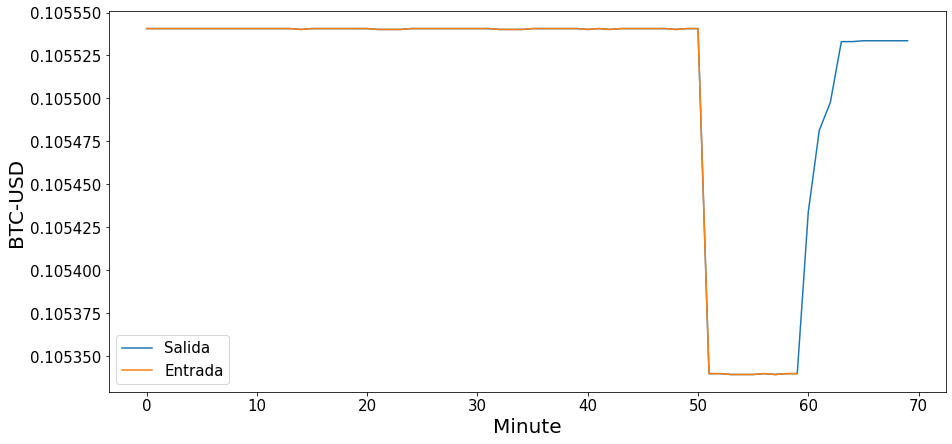

In [6]:
plt.figure(1, figsize=(15,7));
to_plot = np.concatenate((X_val[100,:,0],Y_val[100,59,:]))
plt.plot(to_plot, label='Salida')
plt.plot(range(0,n_steps),X_val[100,:,0], label='Entrada');
plt.xlabel('Minute', fontsize=20);
plt.ylabel('BTC-USD', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(fontsize=15);


In [7]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 2], activation='relu'),    
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, 2]),
    
    keras.layers.TimeDistributed(keras.layers.Dense(10, activation='relu'))
])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer= opt, metrics=[last_time_step_mse])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          180       
_________________________________________________________________
gru (GRU)                    (None, None, 64)          16512     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          650       
Total params: 17,342
Trainable params: 17,342
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, Y_train[:, 3::2], epochs=100,
                    validation_data=(X_val, Y_val[:, 3::2]))\
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_val, Y_val))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Epoch 1/100
953/953 [==============================] - 33s 35ms/step - loss: 0.0017 - last_time_step_mse: 0.0013 - val_loss: 1.0150e-05 - val_last_time_step_mse: 2.0935e-06
Epoch 2/100
953/953 [==============================] - 41s 43ms/step - loss: 5.9236e-06 - last_time_step_mse: 2.4554e-06 - val_loss: 1.0117e-05 - val_last_time_step_mse: 3.3990e-06
Epoch 3/100
953/953 [==============================] - 84s 88ms/step - loss: 5.1151e-06 - last_time_step_mse: 2.2598e-06 - val_loss: 8.0272e-06 - val_last_time_step_mse: 1.6263e-06
Epoch 4/100
953/953 [==============================] - 86s 90ms/step - loss: 5.3359e-06 - last_time_step_mse: 2.6750e-06 - val_loss: 8.4386e-06 - val_last_time_step_mse: 2.1742e-06
Epoch 5/100
953/953 [==============================] - 109s 115ms/step - loss: 5.4235e-06 - last_time_step_mse: 2.8597e-06 - val_loss: 8.2229e-06 - val_last_time_step_mse: 2.0280e-06
Epoch 6/100
953/953 [==============================] - 106s 111ms/step - loss: 5.5011e-06 - last_time

KeyboardInterrupt: 

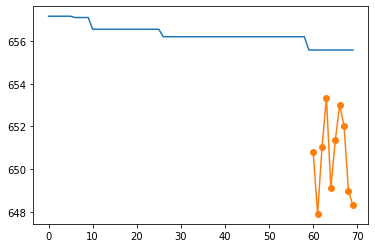

In [10]:
X_plot = X_val[1000, :, 0]
Y_plot = Y_val[1000, -1, :]
X_pred = np.empty((1,60,2))
X_pred[0, :, :] = X_val[1000, :, :]
Y_pred = model.predict(X_pred)[0,-1,:]
X_plot = np.concatenate((X_plot,Y_plot))
plt.plot( scaler_price.inverse_transform(X_plot.reshape(-1,1)))
plt.plot(range(60,70), scaler_price.inverse_transform(Y_pred.reshape(-1,1)), '-o')

In [ ]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [23]:
print(min(history.history['loss']), min(history.history['val_loss']))

5.632401553157251e-06 1.8353741779719712e-06
